In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [2]:
from langgraph.graph import StateGraph, END 
from typing import TypedDict, List, Any
from langgraph.checkpoint.sqlite import SqliteSaver 
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from prompts import *

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    query: str 
    definition: str 
    decomposed_steps: List[str]
    solved_steps: List[str]
    step_history: List[Any]
    completed_step: int

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class Steps(BaseModel):
    steps: List[str]

# class StepPlan(BaseModel):
#     response: str = Field(
#         "Either contains solution of the step if calculator is not needed or" \
#             " includes the query for the calculator"
#     )
#     use_calculator: bool = Field(
#         "defines whether to use calculator or the solution is already finished"
#     )

class StepPlan(BaseModel):
    response: str 
    use_calculator: bool

In [5]:
def problem_definer_node(state: AgentState):
    messages = [
        SystemMessage(content=PROBLEM_DEFINER_PROMPT),
        HumanMessage(content=state['query'])
    ]
    response = llm.invoke(messages)
    return {"definition": response.content}

In [6]:
def problem_decomposer_node(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=Steps)
    
    chain = llm | parser
    system_message = f"{PROBLEM_DECOMPOSER_PROMPT}\n\nFormat Instructions: {parser.get_format_instructions()}"
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=state['definition'])
    ]
    
    steps = chain.invoke(messages)
    return {"decomposed_steps": steps.steps}

In [7]:
def step_iterator(state: AgentState):
    print("Steps completed - ", state['completed_step'])
    if (state['completed_step'] or 0) >= len(state['decomposed_steps']):
        return "end"
    return "generate_step"

In [8]:
def step_generator(state: AgentState):
    solved_steps = state['solved_steps'] or []
    step_count = state['completed_step'] or 0
    messages = state['step_history'] or []
    
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    chain = llm | parser
    
    if len(messages) == 0:
        system_message = STEP_GENERATOR_PROMPT.format(format_instructions=parser.get_format_instructions())
        content = "\n\n".join(solved_steps)
        human_content = f"Original problem definition: {state['query']}. This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=human_content)
        ]
    
    response = chain.invoke(messages)
    messages.append(AIMessage(content=response.json()))
    
    return {
        "step_history": messages
    }

In [9]:
def step_tool_decider(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    if last_response.use_calculator:
        return "calculator"
    return "update_steps"

In [10]:
def update_steps(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    step_count = state['completed_step'] or 0
    step_count += 1
    solved_steps = state['solved_steps'] or []
    solved_steps.append(last_response.response)
    
    return {
        "completed_step": step_count, 
        "solved_steps": solved_steps, 
        "step_history": []
    }

In [11]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper

def calculator(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    wolfram = WolframAlphaAPIWrapper()
    response = wolfram.run(last_response.response)
    human_content = f"With calculator response: {response}. Generate the whole solution."
    messages = state['step_history']
    messages.append(HumanMessage(
        content=human_content
    ))
    
    return {
        "step_history": messages
    }

In [12]:
# def step_generator(state: AgentState):
#     solved_steps = state['solved_steps'] or []
#     step_count = state.get("completed_steps", 0)
#     while step_count != len(state['decomposed_steps']):
#         content = "\n\n".join(solved_steps)
#         human_content = f"Original problem definition: {state['query']}. This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
#         messages = [
#             SystemMessage(content=STEP_GENERATOR_PROMPT),
#             HumanMessage(content=human_content)
#         ]
#         response = llm.invoke(messages)
#         solved_steps.append(response.content)
#         step_count += 1
    
#     return {
#         "solved_steps": solved_steps, 
#         "completed_steps": step_count
#     }

In [13]:
builder = StateGraph(AgentState)

In [14]:
builder.add_node("definer", problem_definer_node)
builder.add_node("decomposer", problem_decomposer_node)
builder.add_node("solver", step_generator)
builder.add_node("calculator", calculator)
builder.add_node("steps_updater", update_steps)
builder.add_node("gateway_node", lambda x:x)

In [15]:
builder.set_entry_point("definer")

In [16]:
builder.add_edge("definer", "decomposer")
builder.add_edge("decomposer", "gateway_node")
builder.add_edge("steps_updater", "gateway_node")
builder.add_edge("calculator", "solver")

In [17]:
builder.add_conditional_edges(
    "gateway_node", 
    step_iterator, 
    {
        "end": END, 
        "generate_step": "solver"
    }
)
builder.add_conditional_edges(
    "solver", 
    step_tool_decider, 
    {
        "calculator": "calculator",
        "update_steps": "steps_updater"
    }
)

In [18]:
graph = builder.compile(checkpointer=memory)

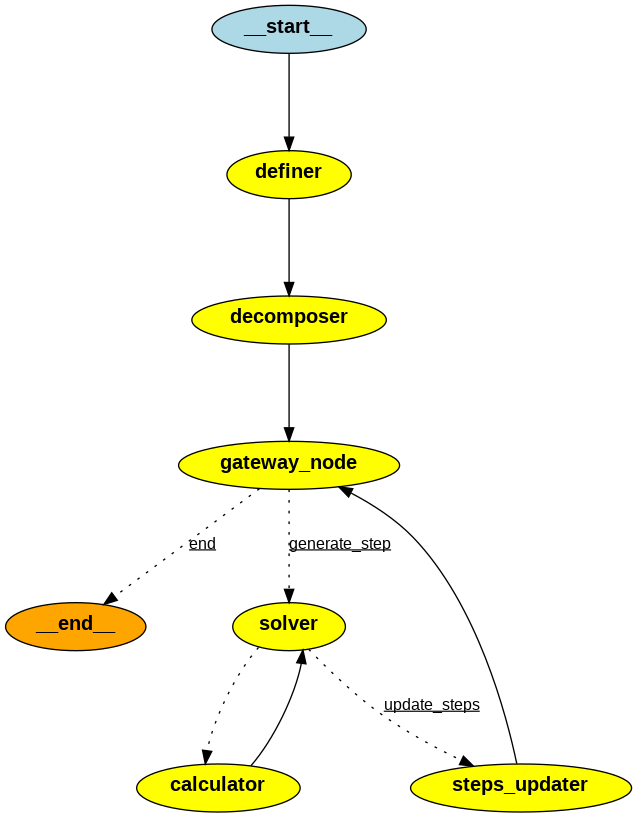

In [19]:
from IPython.display import Image 

Image(graph.get_graph().draw_png())

In [20]:
thread = {"configurable": {"thread_id": 1}}

query = """ 
if x + y + z = pi, prove the trigonometric identity, 
cot(x/2) + cot(y/2) + cot(z/2) = cot(x/2) * cot(y/2) * cot(z/2)
"""

response = graph.invoke({"query": query}, thread)
# for output in graph.stream({"query": "What is the solution for x in sin(x)^3 - cos(x) = 4?"}, thread, stream_mode="updates"):
#     # stream() yields dictionaries with output keyed by node name
#     for key, value in output.items():
#         print(f"Output from node '{key}':")
#         print("---")
#         print(value)
#     print("\n---\n")

Steps completed -  None
Steps completed -  1
Steps completed -  2


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Steps completed -  3
Steps completed -  4
Steps completed -  5


In [21]:
print("\n\n".join(response['solved_steps']))

Applying the identity \(cot(θ) = \frac{cos(θ)}{sin(θ)}\), we can rewrite the equation as:

\(\frac{cos(x/2)}{sin(x/2)} + \frac{cos(y/2)}{sin(y/2)} + \frac{cos(z/2)}{sin(z/2)} = \frac{cos(x/2)}{sin(x/2)} * \frac{cos(y/2)}{sin(y/2)} * \frac{cos(z/2)}{sin(z/2)}\)

Using the relationship \(z = π - (x + y)\), we can rewrite the equation as:

\[ \frac{cos(x/2)}{sin(x/2)} + \frac{cos(y/2)}{sin(y/2)} + \frac{cos(\frac{π - (x + y)}{2})}{sin(\frac{π - (x + y)}{2})} = \frac{cos(x/2)}{sin(x/2)} * \frac{cos(y/2)}{sin(y/2)} * \frac{cos(\frac{π - (x + y)}{2})}{sin(\frac{π - (x + y)}{2})} \]

Now, we'll apply the angle subtraction formulas:

*  \(cos(α - β) = cos(α)cos(β) + sin(α)sin(β)\)
*  \(sin(α - β) = sin(α)cos(β) - cos(α)sin(β)\)

Applying the angle subtraction formulas to the left side of the equation, specifically to the terms  cos(\(\frac{π - (x + y)}{2}\)) and sin(\(\frac{π - (x + y)}{2}\)), we get:

cos(\(\frac{π - (x + y)}{2}\)) = cos(\(\frac{π}{2}\) - \(\frac{x + y}{2}\)) = cos(\(\frac{π}

In [22]:
response['decomposed_steps']

['**Step 1: Express cotangent in terms of sine and cosine.** Use the identity cot(θ) = cos(θ)/sin(θ) to rewrite both sides of the equation.',
 '**Step 2: Apply angle addition and subtraction formulas.**  Use the fact that x + y + z = π to express angles in terms of one another. For example, express z = π - (x + y) and use angle subtraction formulas for sine and cosine.',
 '**Step 3: Simplify the expressions.** Use trigonometric identities to simplify the resulting expressions. Look for common factors and terms that can be canceled.',
 '**Step 4: Manipulate the equation algebraically.** Combine terms, factor, and rearrange the equation to transform the left-hand side into the right-hand side.',
 '**Step 5: Verify the identity.**  After algebraic manipulation, the left-hand side should be identical to the right-hand side, proving the trigonometric identity.']

In [23]:
print(response['definition'])

## Problem Statement:

**Problem Classification:** Trigonometric Identity Proof

**Given:** 
* x, y, and z are angles such that: 
    *  x + y + z = π 

**To Prove:**
* cot(x/2) + cot(y/2) + cot(z/2) = cot(x/2) * cot(y/2) * cot(z/2)

**Available Formulas:**
* Standard trigonometric identities and formulas related to cotangent, such as:
    * cot(θ) = 1/tan(θ) = cos(θ)/sin(θ)
    * Double angle and half-angle formulas.

**Additional Description:** The problem requires proving a trigonometric identity involving the cotangent function, given the constraint that the sum of three angles equals pi (π radians or 180 degrees).  The proof should utilize trigonometric identities and algebraic manipulation to demonstrate the equality of the given expressions. 

